In [1]:
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import torch as th

sys.path.append("..")
from time import time

In [2]:
plt.rcParams.update({"font.size": 16})
plt_params = {"linewidth": 2.7, "alpha": 0.8}


def plot_ci(
    ax,
    data,
    label,
    color="blue",
    linestyle="-",
    tik_step=10,
    do_lines=True,
    plt_params=plt_params,
):
    if do_lines:
        upper = max(round(data.shape[1] / 10) * 10 + 1, data.shape[1] + 1)
        ax.set_xticks(np.arange(0, upper, tik_step))
        for i in range(0, upper, tik_step):
            ax.axvline(i, color="black", linestyle="--", alpha=0.5, linewidth=1)
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    data_ci = {
        "x": np.arange(data.shape[1]) + 1,
        "y": mean,
        "y_upper": mean + (1.96 / (data.shape[0] ** 0.5)) * std,
        "y_lower": mean - (1.96 / (data.shape[0] ** 0.5)) * std,
    }

    df = pd.DataFrame(data_ci)
    # Create the line plot with confidence intervals
    ax.plot(
        df["x"], df["y"], label=label, color=color, linestyle=linestyle, **plt_params
    )
    ax.fill_between(df["x"], df["y_lower"], df["y_upper"], color=color, alpha=0.3)
    if do_lines:
        ax.spines[["right", "top"]].set_visible(False)

In [3]:
def plot_file(file, model_name):
    input_lang = file.split("/")[-1].split("_")[0]
    target_lang = file.split("/")[-1].split("_")[1]
    latent_langs = file.split("/")[-1].split("_")[2:-1]
    with open(file, "r") as f:
        json_dic = json.load(f)
    _, ax = plt.subplots(figsize=(6, 4))
    colors = sns.color_palette("tab10", len(json_dic) + 1)
    target_probs = th.tensor(json_dic[target_lang])
    plot_ci(ax, target_probs, label=target_lang, color=colors[0])
    colors = {lang: color for lang, color in zip(latent_langs, colors[1:])}
    for latent_lang in latent_langs:
        probs = th.tensor(json_dic[latent_lang])
        plot_ci(ax, probs, label=latent_lang, color=colors[latent_lang], do_lines=False)
    ax.legend()
    ax.set_title(
        f"Logit Lens on {model_name}: {input_lang.capitalize()} → {target_lang.capitalize()}"
    )
    ax.tick_params(labelsize=15)
    ax.set_xlabel("Layer", fontsize=16)
    ax.set_ylabel("Token probability", fontsize=16)
    # Save the plot
    path = Path(
        f"plots/{model_name}_art/{input_lang}_{target_lang}_{'_'.join(latent_langs)}_{str(int(time()))}.png"
    )
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

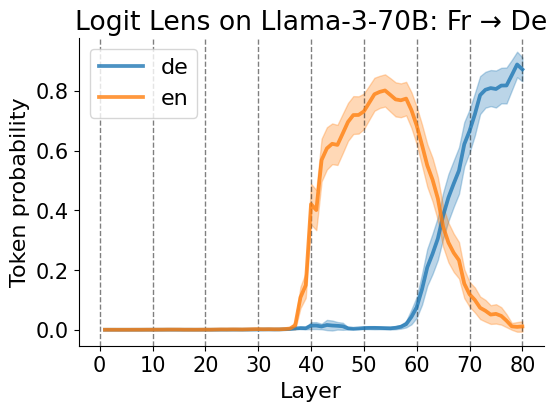

In [4]:
plot_file("results/translation/fr_de_en_1714077535.json", "Llama-3-70B")

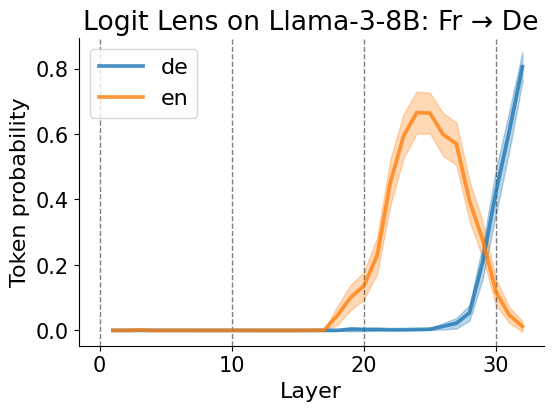

In [5]:
plot_file("results/translation/fr_de_en_1714070982.json", "Llama-3-8B")